In [8]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import seaborn as sns
import ot
import ot.plot
from matplotlib.lines import Line2D

In [9]:
import sys
sys.path.append('../../code/')
from generate_data import make_data_1d
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn
from linear_solver import UOT_W, UOT_KL,UOT_l2,OT
from generate_data import make_data
from utils import kernel

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [11]:
bl="#4A90E2"
o='#F5A623'
v="#7ED321"

In [12]:
def WOP(a,b,X,Y,metric="sqeuclidean"):
    m1=torch.sum(a)
    m2=torch.sum(b)
    #print(m1,m2)
    
    X_dil=(m1*X).clone()
    Y_dil=(m2*Y).clone()
    C=ot.dist(X_dil[:,None],Y_dil[:,None],metric=metric)
    #C=ot.dist(X[:,None],Y[:,None],metric=metric)
    #C/=C.max()
    #print(C.max())
    a_t,b_t=a/m1,b/m2
    return (m1-m2)**2+np.sum(C.numpy()*OT(a_t,b_t,C,solver="CLARABEL"))#,X_dil,Y_dil,ot.emd([],[],ot.dist(X_dil,Y_dil))

# Noise

100 100


/tmp/ipykernel_29121/196497821.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


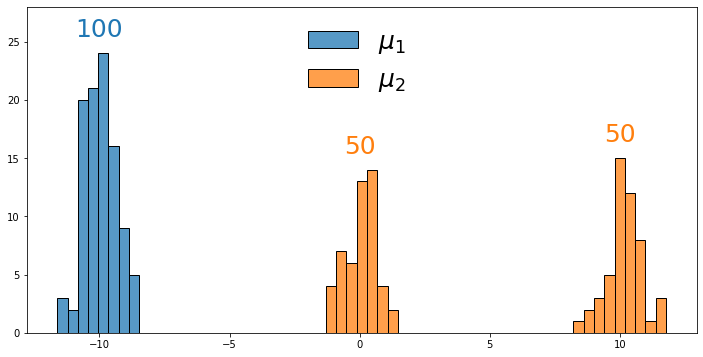

In [19]:
np.random.seed(1)
X,Y=make_data_1d("noise",50)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
fig = pl.figure(figsize=(12,6))
grid = pl.GridSpec(1, 1, wspace=.05,hspace=0.5)
ax=pl.subplot(grid[0, 0])
sns.histplot(x=X, kde=kde,label="$\mu_1$",weights=a,binwidth=.4,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",weights=b,binwidth=.4,kde_kws=dict(bw_adjust=.5),stat="count")
pl.text(-10,26,100 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,16, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(10, 17, 50,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.ylim(0,28)
pl.legend(frameon=False,bbox_to_anchor=(.6,1), prop={'size': 25})
#ax.set_yticks([])
#ax.set_yticklabels([])
##ax.set_xticks([])
##ax.set_xticklabels([])
pl.tight_layout()
pl.xlabel('')
pl.ylabel('')
#pl.savefig("../../Figures/UOT/toy_noise.pdf",bbox_inches='tight')

In [20]:
lam=[400,60]
lam=[400,60]
#print(lam)
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

tensor(76.0340)
tensor(31.4507)


In [21]:
wKL1=[]
wKL2=[]
wKL3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_KL[i]),torch.sum(pi2_KL[i][:50]),torch.sum(pi2_KL[i][50:]))
    wKL1+=[np.round(torch.sum(pi1_KL[i]).numpy(),1)]
    wKL2+=[np.round(torch.sum(pi2_KL[i][:50]).numpy(),1)]
    wKL3+=[np.round(torch.sum(pi2_KL[i][50:]).numpy(),1)]

tensor(76.0340) tensor(51.5389) tensor(24.4951)
tensor(31.4507) tensor(31.1156) tensor(0.3351)


/tmp/ipykernel_29121/641063833.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_29121/641063833.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


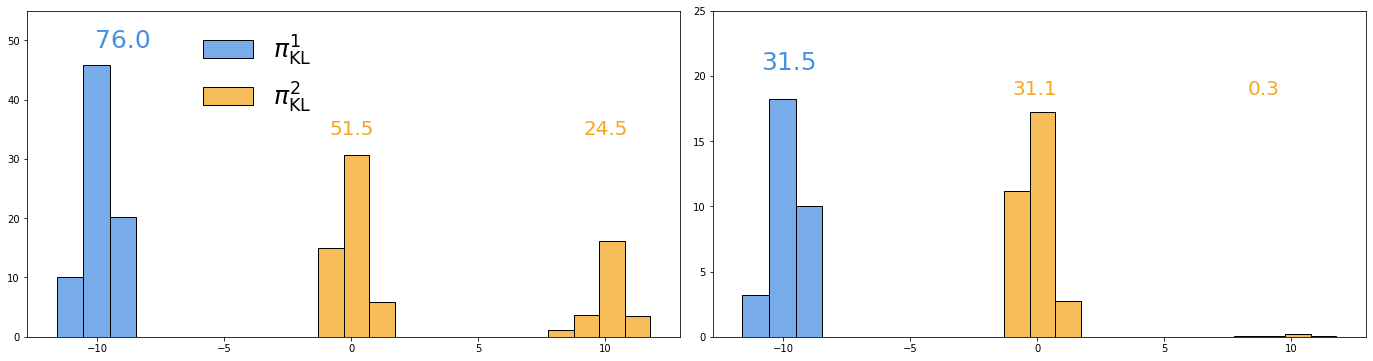

In [22]:
kde=False
fig = pl.figure(figsize=(24,6))
grid = pl.GridSpec(1, len(lam), wspace=.05,hspace=0.5)
for i in range(len(lam)):
    ax=pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="$\pi^1_\mathrm{KL}$",binwidth=1,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5),color=bl)
    sns.histplot(x=Y, kde=kde,label="$\pi^2_\mathrm{KL}$",binwidth=1,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5),color=o)
    if i==0:
        pl.ylim(0,60)
        pl.text(-9,50,wKL1[i],c=bl,alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(0,35, wKL2[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
        pl.text(10, 35, wKL3[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
        pl.ylim(0,55)
    else:
        pl.ylim(0,140)
        pl.text(-9.8,21,wKL1[i],c=bl,alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(-.1,19, wKL2[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
        pl.text(8.9, 19, wKL3[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
        pl.ylim(0,25)
    #pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    pl.tight_layout()
    pl.xlabel('')
    pl.ylabel('')
    if i==0:
        pl.legend(frameon=False,bbox_to_anchor=(.47,1), prop={'size': 25})
#pl.savefig("../../Figures/UOT/toy_noise_KL.pdf",bbox_inches='tight')

In [23]:
lam=[50,7]
Cx,Cy=ot.dist(X[:,None],X[:,None]),ot.dist(Y[:,None],Y[:,None])
P_W=[]
pi1_W=[]
pi2_W=[]
for l in lam:
    P=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_W+=[P]
    pi1_W+=[abs(P)@torch.ones(m)]
    pi2_W+=[abs(P.T)@torch.ones(n)]    

tensor(100.)
tensor(100.0000)


In [24]:
wW1=[]
wW2=[]
wW3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_W[i]),torch.sum(pi2_W[i][:50]),torch.sum(pi2_W[i][50:]))
    wW1+=[np.round(torch.sum(pi1_W[i]).numpy(),1)]
    wW2+=[np.round(torch.sum(pi2_W[i][:50]).numpy(),1)]
    wW3+=[np.round(torch.sum(pi2_W[i][50:]).numpy(),1)]

tensor(100.0000) tensor(50.) tensor(50.)
tensor(100.0000) tensor(50.0000) tensor(50.)


/tmp/ipykernel_29121/1604184264.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_29121/1604184264.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


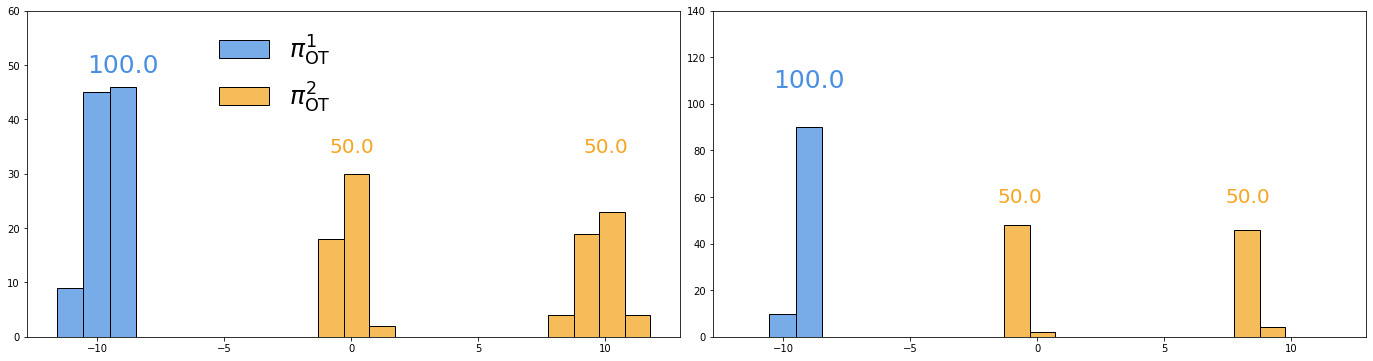

In [25]:
kde=False
fig = pl.figure(figsize=(24,6))
grid = pl.GridSpec(1, len(lam), wspace=.05,hspace=0.5)
for i in range(len(lam)):
    ax=pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="$\pi^1_\mathrm{OT}$",binwidth=1,weights=pi1_W[i],kde_kws=dict(bw_adjust=.5),color=bl)
    sns.histplot(x=Y, kde=kde,label="$\pi^2_\mathrm{OT}$",binwidth=1,weights=pi2_W[i],kde_kws=dict(bw_adjust=.5),color=o)
    if i==0:
        pl.ylim(0,60)
        pl.text(-9,50,wW1[i],c=bl,alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(0,35, wW2[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
        pl.text(10, 35, wW3[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
    else:
        pl.ylim(0,140)
        pl.text(-9,110,wW1[i],c=bl,alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(-.7,60, wW2[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
        pl.text(8.3, 60, wW3[i],c=o,alpha=1,ha="center",va="center",fontsize = 20)
    #pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    pl.tight_layout()
    pl.xlabel('')
    pl.ylabel('')
    if i==0:
        pl.legend(frameon=False,bbox_to_anchor=(.5,1), prop={'size': 25})

#pl.savefig("../../Figures/UOT/toy_noise_OT.pdf",bbox_inches='tight')

### WOP

In [26]:
lam1=np.arange(50,450,20)
#print(lam)
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam1:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    #print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)] 
    
lam2=np.arange(5,60,4)
#print(lam)
P_OT=[]
pi1_OT=[]
pi2_OT=[]
for l in lam2:
    P=UOT_W(a,b,C,lam=l,Cx=Cx,Cy=Cy,solver="CLARABEL")
    P=torch.tensor(P).float()
    #print(torch.sum(P))
    P_OT+=[P]
    pi1_OT+=[P@torch.ones(m)]
    pi2_OT+=[(P.T)@torch.ones(n)]    

/home/gui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [27]:
#calcul WOP
WOP1_KL=[]
WOP2_KL=[]
for i in range(len(lam1)):
    WOP1_KL+=[np.sqrt(WOP(a/100,pi1_KL[i]/100,X,X))]
    WOP2_KL+=[np.sqrt(WOP(b/100,pi2_KL[i]/100,Y,Y))]

In [28]:
#calcul WOP
WOP1_OT=[]
WOP2_OT=[]
for i in range(len(lam2)):
    WOP1_OT+=[WOP(a/100,pi1_OT[i]/100,X,X)]
    WOP2_OT+=[WOP(b/100,pi2_OT[i]/100,Y,Y)]
    #C=ot.dist(X[:,None],X[:,None])
    #P=OT(a/100,pi1_OT[i]/100,C)
    #print(np.sum(P*C.numpy()))

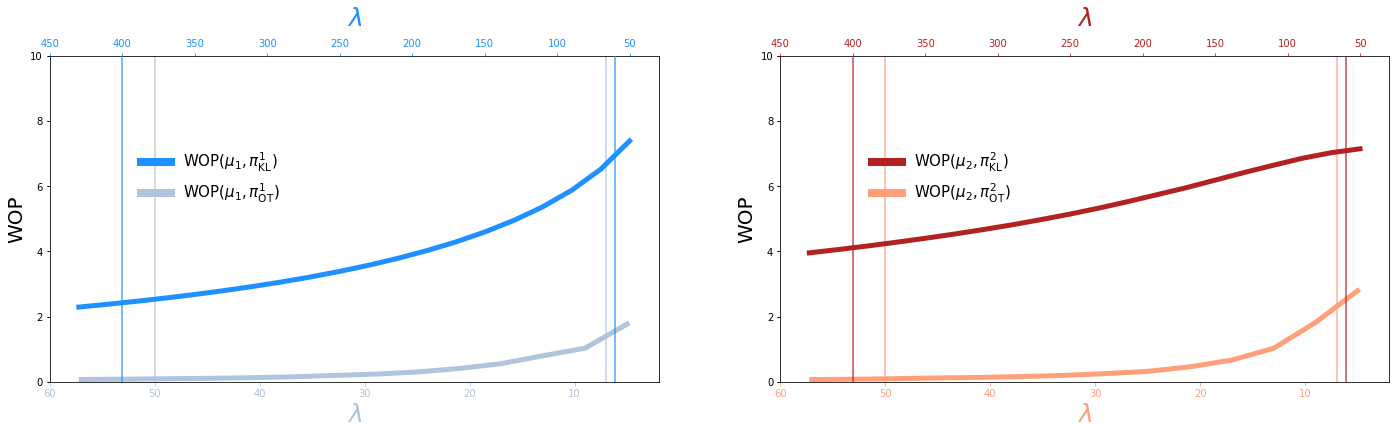

In [29]:
fig=pl.figure(figsize=(24,6))
#ax.axvline(100,c="grey",alpha=0.8,linewidth=3)

ax1=fig.add_subplot(121)
ax1.plot(lam2,WOP1_OT,linewidth=5,color="lightsteelblue")
ax1.set_ylim([0, 10])
ax1.set_xlim([lam2[0]-3, lam2[-1]+3])
ax1.invert_xaxis()
ax1.set_xlabel("$\lambda$", color="lightsteelblue",size=25)
ax1.set_ylabel("WOP",size=20)
ax1.tick_params(axis='x', colors="lightsteelblue")
pl.axvline(50,c="lightsteelblue",alpha=0.8)
pl.axvline(7,c="lightsteelblue",alpha=0.8)

ax2=fig.add_subplot(121, frame_on=False)
ax2.plot(lam1,WOP1_KL,linewidth=5,color="dodgerblue")
ax2.xaxis.tick_top()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticklabels())
#ax2.set_ylim([0, 10])
ax2.set_xlim([lam1[0]-20, lam1[-1]+20])
ax2.invert_xaxis()
ax2.set_xlabel("$\lambda$", color="dodgerblue",size=25)
ax2.xaxis.set_label_coords(.5, 1.15)
pl.axvline(400,c="dodgerblue",alpha=0.8)
pl.axvline(60,c="dodgerblue",alpha=0.8)
ax2.tick_params(axis='x', colors="dodgerblue")

label2 = Line2D([0], [0], label="WOP$(\mu_1,\pi_\mathrm{OT}^1)$", color="lightsteelblue", linestyle='-',linewidth=8)
label1 = Line2D([0], [0], label="WOP$(\mu_1,\pi^1_\mathrm{KL})$", color="dodgerblue", linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.4,.75),handles=handles, prop={'size': 15})

ax1=fig.add_subplot(122)
ax1.plot(lam2,WOP2_OT,linewidth=5,color="lightsalmon")
ax1.set_ylim([0, 10])
ax1.set_xlim([lam2[0]-3, lam2[-1]+3])
ax1.invert_xaxis()
ax1.set_xlabel("$\lambda$", color="lightsalmon",size=25)
ax1.set_ylabel("WOP",size=20)
ax1.tick_params(axis='x', colors="lightsalmon")
pl.axvline(50,c="lightsalmon",alpha=0.8)
pl.axvline(7,c="lightsalmon",alpha=0.8)

ax2=fig.add_subplot(122, frame_on=False)
ax2.plot(lam1,WOP2_KL,linewidth=5,color="firebrick")
ax2.xaxis.tick_top()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticklabels())
#ax2.set_ylim([0, 10])
ax2.set_xlim([lam1[0]-20, lam1[-1]+20])
ax2.invert_xaxis()
ax2.set_xlabel("$\lambda$", color="firebrick",size=25)
ax2.xaxis.set_label_coords(.5, 1.15)
pl.axvline(400,c="firebrick",alpha=0.8)
pl.axvline(60,c="firebrick",alpha=0.8)
ax2.tick_params(axis='x', colors="firebrick")

label2 = Line2D([0], [0], label="WOP$(\mu_2,\pi_\mathrm{OT}^2)$", color="lightsalmon", linestyle='-',linewidth=8)
label1 = Line2D([0], [0], label="WOP$(\mu_2,\pi^2_\mathrm{KL})$", color="firebrick", linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.4,.75),handles=handles, prop={'size': 15})

#pl.savefig("../../Figures/UOT/toy_noise_WOP.pdf",bbox_inches='tight')

# death birth

80 110


/tmp/ipykernel_29121/1734340537.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


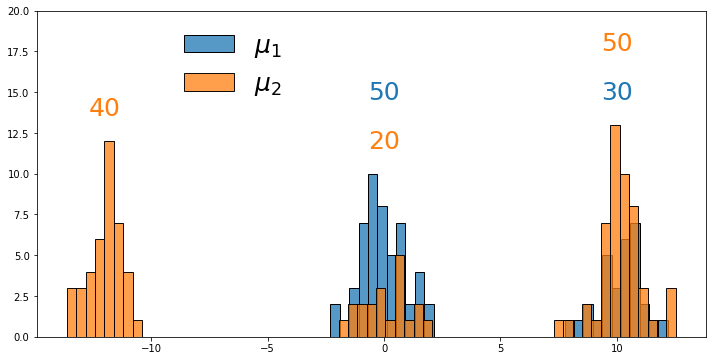

In [30]:
np.random.seed(1)
n0=10
X,Y=make_data_1d("death_birth",n0)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
fig = pl.figure(figsize=(12,6))
grid = pl.GridSpec(1, 1, wspace=.05,hspace=0.5)
ax=pl.subplot(grid[0, 0])
sns.histplot(x=X, kde=kde,label="$\mu_1$",binwidth=.4,weights=a,kde_kws=dict(bw_adjust=.1))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",binwidth=.4,weights=b,kde_kws=dict(bw_adjust=.1))
pl.text(0,15,50 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(10,15,30 ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(-12, 14, 40,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(0,12,20 ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.text(10,18,50 ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
pl.ylim(0,20)
#ax.set_yticks([])
#ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_xticklabels([])
pl.tight_layout()
pl.xlabel('')
pl.ylabel('')
pl.legend(frameon=False,bbox_to_anchor=(.4,1), prop={'size': 25})
#pl.savefig("../../Figures/UOT/toy_deathbirth.pdf",bbox_inches='tight')

In [31]:
lam=[150,30]#,100,120,500]
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

tensor(82.2649)
tensor(71.5114)


In [32]:
wKL1=[]
wKL2=[]
wKL3=[]
wKL4=[]
wKL5=[]
for i in range(len(lam)):
    print(1,torch.sum(pi1_KL[i][:5*n0]),torch.sum(pi1_KL[i][5*n0:]))
    print(2,torch.sum(pi2_KL[i][:4*n0]),torch.sum(pi2_KL[i][4*n0:6*n0]),torch.sum(pi2_KL[i][6*n0:]))
    wKL1+=[int(np.round(torch.sum(pi1_KL[i][:5*n0]).numpy()))]
    wKL2+=[int(np.round(torch.sum(pi1_KL[i][5*n0:]).numpy()))]
    wKL3+=[int(np.round(torch.sum(pi2_KL[i][:4*n0]).numpy()))]
    wKL4+=[int(np.round(torch.sum(pi2_KL[i][4*n0:6*n0]).numpy()))]
    wKL5+=[int(np.round(torch.sum(pi2_KL[i][6*n0:]).numpy()))]

1 tensor(45.0282) tensor(37.2367)
2 tensor(18.8577) tensor(22.9655) tensor(40.4417)
1 tensor(32.8189) tensor(38.6925)
2 tensor(1.8806) tensor(30.9384) tensor(38.6925)


/tmp/ipykernel_29121/3069380575.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_29121/3069380575.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


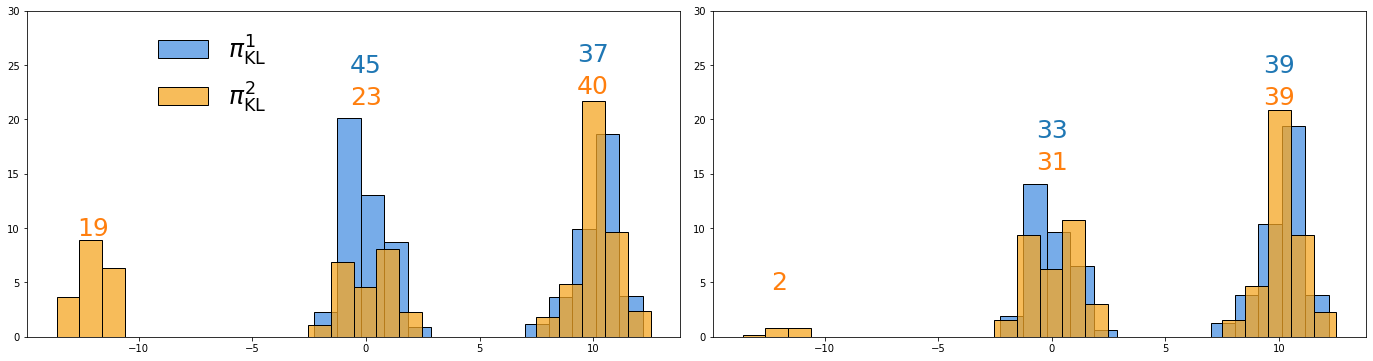

In [33]:
kde=False
fig = pl.figure(figsize=(24,6))
grid = pl.GridSpec(1, len(lam), wspace=.05,hspace=0.5)
for i in range(len(lam)):
    ax=pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="$\pi^1_\mathrm{KL}$",binwidth=1,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5),color=bl)
    sns.histplot(x=Y, kde=kde,label="$\pi^2_\mathrm{KL}$",binwidth=1,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5),color=o)
    if i==0:
        pl.text(0,25,wKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,26, wKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(-12, 10, wKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(0,22,wKL4[i] ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,23, wKL5[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
    else:
        pl.text(0,19,wKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,25, wKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(-12, 5, wKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(0,16,wKL4[i] ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,22, wKL5[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
    #pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    pl.tight_layout()
    pl.xlabel('')
    pl.ylabel('')
    pl.ylim(0,30)
    if i==0:
        pl.legend(frameon=False,bbox_to_anchor=(.4,1), prop={'size': 25})

#pl.savefig("../../Figures/UOT/toy_deathbirth_KL.pdf",bbox_inches='tight')

In [34]:
lam=[12,3]#,100,120,500]
Kx,Ky=kernel(X[:,None],Y[:,None],sigma=1,k="gaussian")
P_KKL=[]
pi1_KKL=[]
pi2_KKL=[]
for l in lam:
    #P=UOT_MMD(a,b,C,lam=l,Kx=Kx,Ky=Ky,solver="CLARABEL",regul=1e-2)
    u,v,G=logsinkhorn(a,b,C,lam=l,eps=2e0,numiter=500,pen="kkl",
                      Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    print(torch.sum(P))
    P_KKL+=[P]
    pi1_KKL+=[abs(P)@torch.ones(m)]
    pi2_KKL+=[abs(P.T)@torch.ones(n)]    

tensor(102.8209)
tensor(104.7364)


In [35]:
wKKL1=[]
wKKL2=[]
wKKL3=[]
wKKL4=[]
wKKL5=[]
for i in range(len(lam)):
    print(1,torch.sum(pi1_KKL[i][:5*n0]),torch.sum(pi1_KKL[i][5*n0:]))
    print(2,torch.sum(pi2_KKL[i][:4*n0]),torch.sum(pi2_KKL[i][4*n0:6*n0]),torch.sum(pi2_KKL[i][6*n0:]))
    wKKL1+=[int(np.round(torch.sum(pi1_KKL[i][:5*n0]).numpy()))]
    wKKL2+=[int(np.round(torch.sum(pi1_KKL[i][5*n0:]).numpy()))]
    wKKL3+=[int(np.round(torch.sum(pi2_KKL[i][:4*n0]).numpy()))]
    wKKL4+=[int(np.round(torch.sum(pi2_KKL[i][4*n0:6*n0]).numpy()))]
    wKKL5+=[int(np.round(torch.sum(pi2_KKL[i][6*n0:]).numpy()))]

1 tensor(59.1216) tensor(43.6992)
2 tensor(34.4213) tensor(23.3576) tensor(45.0420)
1 tensor(60.2172) tensor(44.5193)
2 tensor(19.2979) tensor(40.9173) tensor(44.5213)


/tmp/ipykernel_29121/337327160.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_29121/337327160.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


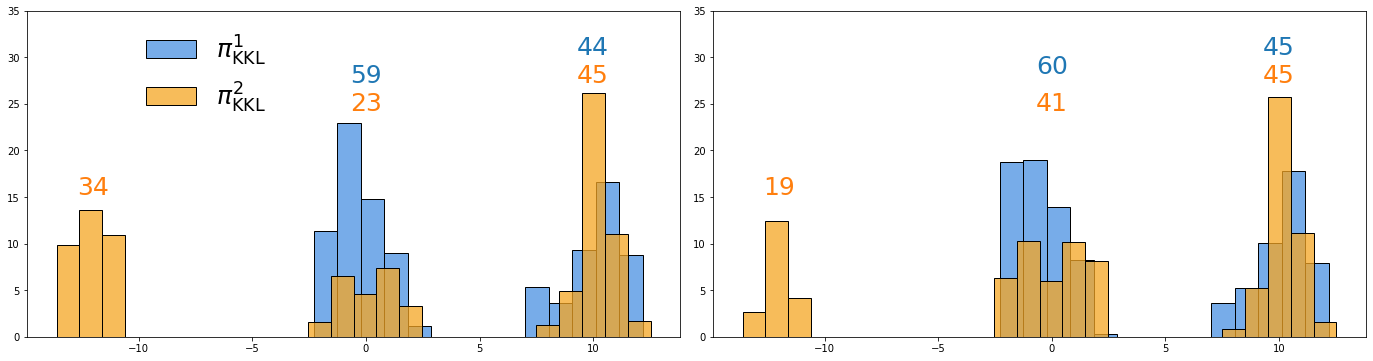

In [36]:
kde=False
fig = pl.figure(figsize=(24,6))
grid = pl.GridSpec(1, len(lam), wspace=.05,hspace=0.5)
for i in range(len(lam)):
    ax=pl.subplot(grid[0, i])
    sns.histplot(x=X, kde=kde,label="$\pi^1_\mathrm{KKL}$",binwidth=1,weights=pi1_KKL[i],kde_kws=dict(bw_adjust=.5),color=bl)
    sns.histplot(x=Y, kde=kde,label="$\pi^2_\mathrm{KKL}$",binwidth=1,weights=pi2_KKL[i],kde_kws=dict(bw_adjust=.5),color=o)
    if i==0:
        pl.text(0,28,wKKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,31, wKKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(-12, 16, wKKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(0,25,wKKL4[i] ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,28, wKKL5[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
    else:
        pl.text(0,29,wKKL1[i] ,c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,31, wKKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(-12, 16, wKKL3[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(0,25,wKKL4[i] ,c="C1",alpha=1,ha="center",va="center",fontsize = 25)
        pl.text(10,28, wKKL5[i],c="C1",alpha=1,ha="center",va="center",fontsize = 25)
    #pl.title("KL and $\lambda =$ %i"%lam[i],size=20)
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    pl.tight_layout()
    pl.xlabel('')
    pl.ylabel('')
    pl.ylim(0,35)
    if i==0:
        pl.legend(frameon=False,bbox_to_anchor=(.4,1), prop={'size': 25})

#pl.savefig("../../Figures/UOT/toy_deathbirth_KKL.pdf",bbox_inches='tight')

### WOP

In [37]:
lam1=np.arange(22,180,10)
#print(lam)
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam1:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)] 
    
lam2=np.arange(2,15,2)
#print(lam)
P_KKL=[]
pi1_KKL=[]
pi2_KKL=[]
for l in lam2:
    u,v,G=logsinkhorn(a,b,C,lam=l,eps=2.7e0,numiter=100,pen="kkl",Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    print(P.sum())
    P_KKL+=[P]
    pi1_KKL+=[P@torch.ones(m)]
    pi2_KKL+=[(P.T)@torch.ones(n)]    

tensor(70.7363)
tensor(71.7033)
tensor(72.6970)
tensor(73.8570)
tensor(75.0321)
tensor(76.1494)
tensor(77.1912)
tensor(78.1575)
tensor(79.0378)
tensor(79.8357)
tensor(80.5613)
tensor(81.2225)
tensor(81.8219)
tensor(82.3711)
tensor(82.8758)
tensor(83.3399)
tensor(101.9231)
tensor(103.1176)
tensor(100.8728)
tensor(100.1990)
tensor(100.1184)
tensor(100.1466)
tensor(100.1360)


In [38]:
#calcul WOP
WOP1_KL=[]
WOP2_KL=[]
for i in range(len(lam1)):
    WOP1_KL+=[np.sqrt(WOP(a/100,pi1_KL[i]/100,X,X))]
    WOP2_KL+=[np.sqrt(WOP(b/100,pi2_KL[i]/100,Y,Y))]

In [39]:
#calcul WOP
WOP1_KKL=[]
WOP2_KKL=[]
for i in range(len(lam2)):
    WOP1_KKL+=[WOP(a/100,pi1_KKL[i]/100,X,X)]
    WOP2_KKL+=[WOP(b/100,pi2_KKL[i]/100,Y,Y)]
    #C=ot.dist(X[:,None],X[:,None])
    #P=OT(a/100,pi1_OT[i]/100,C)
    #print(np.sum(P*C.numpy()))

/home/gui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


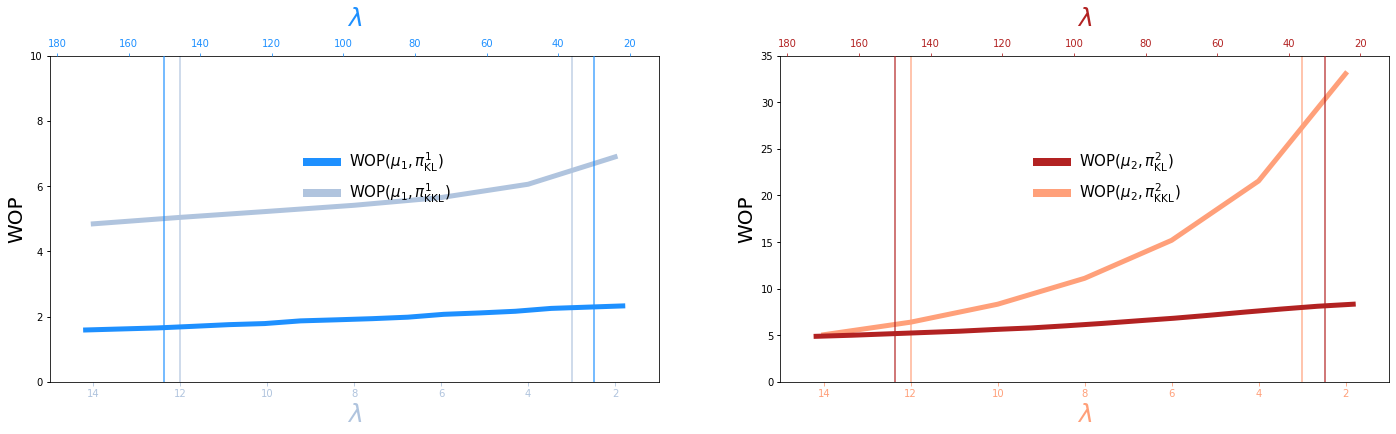

In [40]:
fig=pl.figure(figsize=(24,6))
#ax.axvline(100,c="grey",alpha=0.8,linewidth=3)

ax1=fig.add_subplot(121)
ax1.plot(lam2,WOP1_KKL,linewidth=5,color="lightsteelblue")
ax1.set_ylim([0, 10])
ax1.set_xlim([lam2[0]-1, lam2[-1]+1])
ax1.invert_xaxis()
ax1.set_xlabel("$\lambda$", color="lightsteelblue",size=25)
ax1.set_ylabel("WOP",size=20)
ax1.tick_params(axis='x', colors="lightsteelblue")
pl.axvline(12,c="lightsteelblue",alpha=0.8)
pl.axvline(3,c="lightsteelblue",alpha=0.8)

ax2=fig.add_subplot(121, frame_on=False)
ax2.plot(lam1,WOP1_KL,linewidth=5,color="dodgerblue")
ax2.xaxis.tick_top()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticklabels())
#ax2.set_ylim([0, 10])
ax2.set_xlim([lam1[0]-10, lam1[-1]+10])
ax2.invert_xaxis()
ax2.set_xlabel("$\lambda$", color="dodgerblue",size=25)
ax2.xaxis.set_label_coords(.5, 1.15)
pl.axvline(150,c="dodgerblue",alpha=0.8)
pl.axvline(30,c="dodgerblue",alpha=0.8)
ax2.tick_params(axis='x', colors="dodgerblue")

label2 = Line2D([0], [0], label="WOP$(\mu_1,\pi_\mathrm{KKL}^1)$", color="lightsteelblue", linestyle='-',linewidth=8)
label1 = Line2D([0], [0], label="WOP$(\mu_1,\pi^1_\mathrm{KL})$", color="dodgerblue", linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.4,.75),handles=handles, prop={'size': 15})

ax1=fig.add_subplot(122)
ax1.plot(lam2,WOP2_KKL,linewidth=5,color="lightsalmon")
ax1.set_ylim([0, 35])
ax1.set_xlim([lam2[0]-1, lam2[-1]+1])
ax1.invert_xaxis()
ax1.set_xlabel("$\lambda$", color="lightsalmon",size=25)
ax1.set_ylabel("WOP",size=20)
ax1.tick_params(axis='x', colors="lightsalmon")
pl.axvline(12,c="lightsalmon",alpha=0.8)
pl.axvline(3,c="lightsalmon",alpha=0.8)

ax2=fig.add_subplot(122, frame_on=False)
ax2.plot(lam1,WOP2_KL,linewidth=5,color="firebrick")
ax2.xaxis.tick_top()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticklabels())
#ax2.set_ylim([0, 10])
ax2.set_xlim([lam1[0]-10, lam1[-1]+10])
ax2.invert_xaxis()
ax2.set_xlabel("$\lambda$", color="firebrick",size=25)
ax2.xaxis.set_label_coords(.5, 1.15)
pl.axvline(150,c="firebrick",alpha=0.8)
pl.axvline(30,c="firebrick",alpha=0.8)
ax2.tick_params(axis='x', colors="firebrick")

label2 = Line2D([0], [0], label="WOP$(\mu_2,\pi_\mathrm{KKL}^2)$", color="lightsalmon", linestyle='-',linewidth=8)
label1 = Line2D([0], [0], label="WOP$(\mu_2,\pi^2_\mathrm{KL})$", color="firebrick", linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.4,.75),handles=handles, prop={'size': 15})

#pl.savefig("../../Figures/UOT/toy_deathbirth_WOP.pdf",bbox_inches='tight')

In [41]:
WOP2_KL

[tensor(8.3267),
 tensor(8.1062),
 tensor(7.8095),
 tensor(7.4889),
 tensor(7.1459),
 tensor(6.8232),
 tensor(6.5490),
 tensor(6.2662),
 tensor(6.0136),
 tensor(5.7799),
 tensor(5.6171),
 tensor(5.4277),
 tensor(5.2866),
 tensor(5.1425),
 tensor(4.9977),
 tensor(4.8807)]

# Case 1 : Outliers

99 100


/tmp/ipykernel_29121/692604981.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


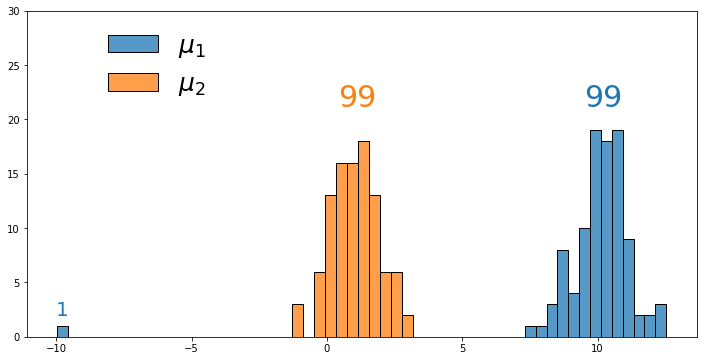

In [42]:
np.random.seed(1)
X,Y=make_data_1d("outlier",33)
n,m=X.shape[0],Y.shape[0]
a,b=torch.ones((n,)),torch.ones((m,))
print(n,m)
C=ot.dist(X[:,None],Y[:,None])

kde=False
fig = pl.figure(figsize=(12,6))
grid = pl.GridSpec(1, 1, wspace=.05,hspace=0.5)
ax=pl.subplot(grid[0, 0])
sns.histplot(x=Y, kde=kde,label="$\mu_1$",binwidth=.4,weights=b,kde_kws=dict(bw_adjust=.1),color='C0')
sns.histplot(x=X, kde=kde,label="$\mu_2$",binwidth=.4,weights=a,kde_kws=dict(bw_adjust=.1),color='C1')
pl.text(1.1,22, "99",c="C1",alpha=1,ha="center",va="center",fontsize = 30)
pl.text(10.2,22, "99",c="C0",alpha=1,ha="center",va="center",fontsize = 30)
pl.text(-9.8, 2.5, "1",c="C0",alpha=1,ha="center",va="center",fontsize = 20)
pl.ylim(0,30)
##ax.set_yticks([])
##ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_xticklabels([])
pl.tight_layout()
pl.xlabel('')
pl.ylabel('')
pl.legend(frameon=False,bbox_to_anchor=(.3,1), prop={'size': 25})
#pl.savefig("../../Figures/UOT/toy_outlier.pdf",bbox_inches='tight')

In [43]:
lam=[200,15]#,100,120,500]
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)]    

/home/gui/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


tensor(81.3070)
tensor(10.5705)


In [44]:
wKL1=[]
wKL2=[]
wKL3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_KL[i]),torch.sum(pi2_KL[i][:99]),torch.sum(pi2_KL[i][99:]))
    wKL1+=[np.round(torch.sum(pi1_KL[i]).numpy(),1)]
    wKL2+=[np.round(torch.sum(pi2_KL[i][:99]).numpy(),1)]
    wKL3+=[np.round(torch.sum(pi2_KL[i][99:]).numpy(),1)]

tensor(81.3070) tensor(80.3166) tensor(0.9904)
tensor(10.5705) tensor(10.4322) tensor(0.1382)


/tmp/ipykernel_29121/4035974926.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_29121/4035974926.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


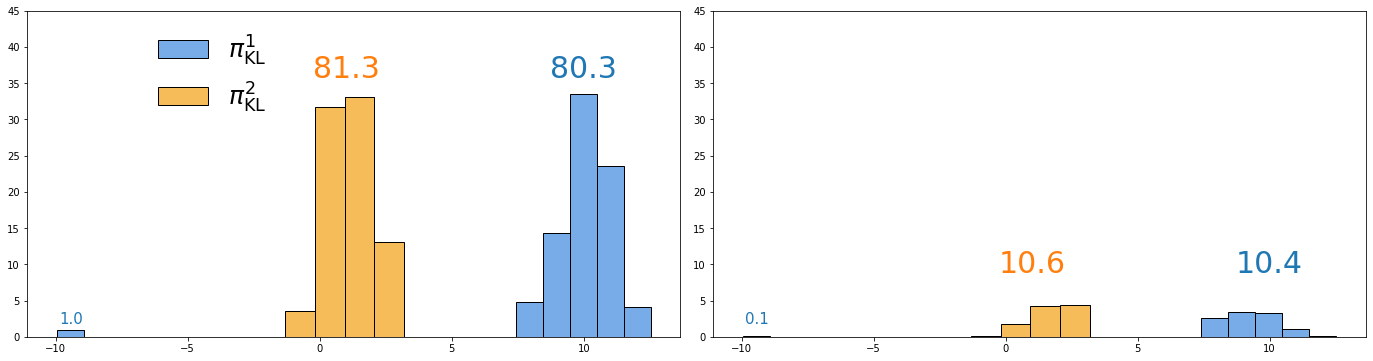

In [45]:
kde=False
fig = pl.figure(figsize=(24,6))
grid = pl.GridSpec(1, len(lam), wspace=.05,hspace=0.5)
for i in range(len(lam)):
    ax=pl.subplot(grid[0, i])
    sns.histplot(x=Y, kde=kde,label="$\pi^1_\mathrm{KL}$",binwidth=1,weights=pi2_KL[i],kde_kws=dict(bw_adjust=.5),color=bl)
    sns.histplot(x=X, kde=kde,label="$\pi^2_\mathrm{KL}$",binwidth=1,weights=pi1_KL[i],kde_kws=dict(bw_adjust=.5),color=o)
    if i==0:
        pl.text(1,37, wKL1[i],c="C1",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(10,37, wKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(-9.4, 2.5, wKL3[i],c="C0",alpha=1,ha="center",va="center",fontsize = 15)
    else:
        pl.text(1,10, wKL1[i],c="C1",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(10,10, wKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(-9.4, 2.5, wKL3[i],c="C0",alpha=1,ha="center",va="center",fontsize = 15)
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    pl.tight_layout()
    pl.xlabel('')
    pl.ylabel('')
    pl.ylim(0,45)
    if i==0:
        pl.legend(frameon=False,bbox_to_anchor=(.4,1), prop={'size': 25})

#pl.savefig("../../Figures/UOT/toy_outlier_KL.pdf",bbox_inches='tight')

In [46]:
lam=[15,3]
Kx,Ky=kernel(X[:,None],Y[:,None],sigma=1,k="gaussian")
P_KKL=[]
pi1_KKL=[]
pi2_KKL=[]
for l in lam:
    #P=UOT_KKL(a,b,C,lam=l,Kx=Kx,Ky=Ky,solver="CLARABEL",regul=1e0)
    u,v,G=logsinkhorn(a,b,C,lam=l,eps=1e0,numiter=500,pen="kkl",
                      Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    print(torch.sum(P))
    P_KKL+=[P]
    pi1_KKL+=[abs((P)@torch.ones(m))]
    pi2_KKL+=[abs((P.T)@torch.ones(n))]    

tensor(95.2901)
tensor(87.2759)


In [47]:
wKKL1=[]
wKKL2=[]
wKKL3=[]
for i in range(len(lam)):
    print(torch.sum(pi1_KKL[i]),torch.sum(pi2_KKL[i][:99]),torch.sum(pi2_KKL[i][99:]))
    wKKL1+=[np.round(torch.sum(pi1_KKL[i]).numpy(),1)]
    wKKL2+=[np.round(torch.sum(pi2_KKL[i][:99]).numpy(),1)]
    wKKL3+=[np.round(torch.sum(pi2_KKL[i][99:]).numpy(),1)]

tensor(95.2901) tensor(94.6823) tensor(0.6079)
tensor(87.2759) tensor(87.2619) tensor(0.0139)


/tmp/ipykernel_29121/3077576029.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/tmp/ipykernel_29121/3077576029.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


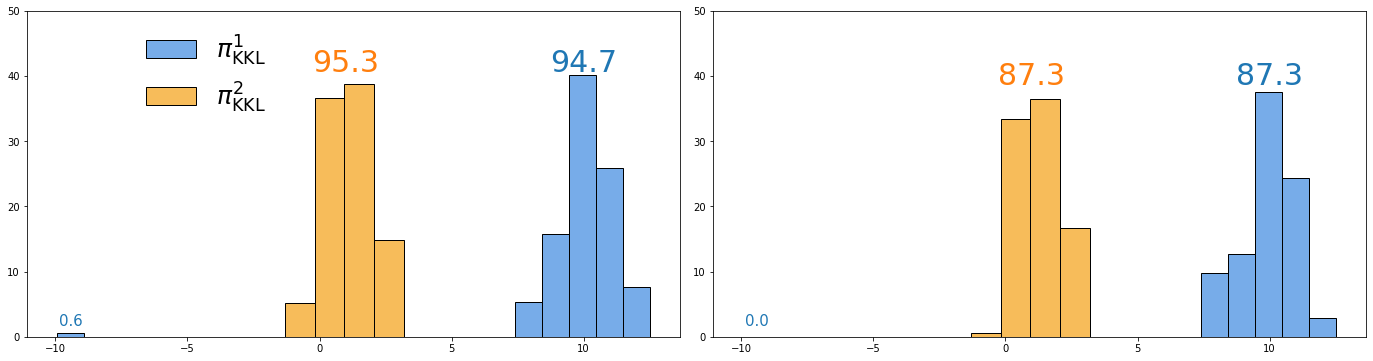

In [48]:
kde=False
fig = pl.figure(figsize=(24,6))
grid = pl.GridSpec(1, len(lam), wspace=.05,hspace=0.5)
for i in range(len(lam)):
    ax=pl.subplot(grid[0, i])
    sns.histplot(x=Y, kde=kde,label="$\pi^1_\mathrm{KKL}$",binwidth=1,weights=pi2_KKL[i],kde_kws=dict(bw_adjust=.5),color=bl)
    sns.histplot(x=X, kde=kde,label="$\pi^2_\mathrm{KKL}$",binwidth=1,weights=pi1_KKL[i],kde_kws=dict(bw_adjust=.5),color=o)
    
    if i==0:
        pl.text(1,42, wKKL1[i],c="C1",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(10,42, wKKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(-9.4, 2.5, wKKL3[i],c="C0",alpha=1,ha="center",va="center",fontsize = 15)
    else:
        pl.text(1,40, wKKL1[i],c="C1",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(10,40, wKKL2[i],c="C0",alpha=1,ha="center",va="center",fontsize = 30)
        pl.text(-9.4, 2.5, wKKL3[i],c="C0",alpha=1,ha="center",va="center",fontsize = 15)
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_xticklabels([])
    pl.tight_layout()
    pl.xlabel('')
    pl.ylabel('')
    pl.ylim(0,50)
    if i==0:
        pl.legend(frameon=False,bbox_to_anchor=(.4,1), prop={'size': 25})

#pl.savefig("../../Figures/UOT/toy_outlier_KKL.pdf",bbox_inches='tight')

### WOP

In [49]:
lam1=np.arange(4,230,10)
#print(lam)
P_KL=[]
pi1_KL=[]
pi2_KL=[]
for l in lam1:
    P=UOT_KL(a,b,C,lam=l,solver="CLARABEL")
    P=torch.tensor(P).float()
    print(torch.sum(P))
    P_KL+=[P]
    pi1_KL+=[P@torch.ones(m)]
    pi2_KL+=[(P.T)@torch.ones(n)] 
    
lam2=np.arange(2,18,2)
#print(lam)
P_KKL=[]
pi1_KKL=[]
pi2_KKL=[]
for l in lam2:
    u,v,G=logsinkhorn(a,b,C,lam=l,eps=1e0,numiter=100,pen="kkl",Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    print(P.sum())
    P_KKL+=[P]
    pi1_KKL+=[P@torch.ones(m)]
    pi2_KKL+=[(P.T)@torch.ones(n)]    

tensor(0.2972)
tensor(9.2828)
tensor(22.1509)
tensor(33.1446)
tensor(41.8186)
tensor(48.6455)
tensor(54.0963)
tensor(58.5274)
tensor(62.1911)
tensor(65.2654)
tensor(67.8791)
tensor(70.1266)
tensor(72.0790)
tensor(73.7903)
tensor(75.3022)
tensor(76.6472)
tensor(77.8515)
tensor(78.9358)
tensor(79.9172)
tensor(80.8095)
tensor(81.6242)
tensor(82.3712)
tensor(83.0584)
tensor(83.0210)
tensor(90.5210)
tensor(93.3902)
tensor(95.0324)
tensor(95.8725)
tensor(96.1488)
tensor(96.1847)
tensor(96.1339)


In [50]:
#calcul WOP
WOP1_KL=[]
WOP2_KL=[]
for i in range(len(lam1)):
    WOP1_KL+=[np.sqrt(WOP(a/100,pi1_KL[i]/100,X,X))]
    WOP2_KL+=[np.sqrt(WOP(b/100,pi2_KL[i]/100,Y,Y))]

In [51]:
#WOP2_KL[14]=2.6

In [52]:
#calcul WOP
WOP1_KKL=[]
WOP2_KKL=[]
for i in range(len(lam2)):
    WOP1_KKL+=[WOP(a/100,pi1_KKL[i]/100,X,X)]
    WOP2_KKL+=[WOP(b/100,pi2_KKL[i]/100,Y,Y)]
    #C=ot.dist(X[:,None],X[:,None])
    #P=OT(a/100,pi1_OT[i]/100,C)
    #print(np.sum(P*C.numpy()))

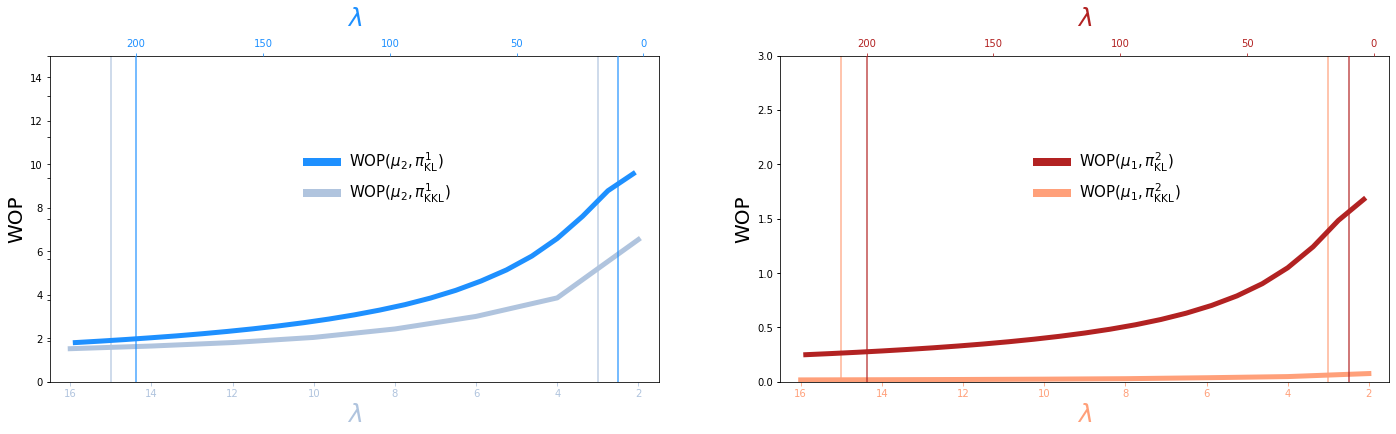

In [53]:
fig=pl.figure(figsize=(24,6))
#ax.axvline(100,c="grey",alpha=0.8,linewidth=3)


ax1=fig.add_subplot(121)
ax1.plot(lam2,WOP2_KKL,linewidth=5,color="lightsteelblue")
ax1.set_ylim([0, 15])
ax1.set_xlim([lam2[0]-.5, lam2[-1]+.5])
ax1.invert_xaxis()
ax1.set_xlabel("$\lambda$", color="lightsteelblue",size=25)
ax1.set_ylabel("WOP",size=20)
ax1.tick_params(axis='x', colors="lightsteelblue")
pl.axvline(15,c="lightsteelblue",alpha=0.8)
pl.axvline(3,c="lightsteelblue",alpha=0.8)

ax2=fig.add_subplot(121, frame_on=False)
ax2.plot(lam1,WOP2_KL,linewidth=5,color="dodgerblue")
ax2.xaxis.tick_top()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticklabels())
#ax2.set_ylim([0, 10])
ax2.set_xlim([lam1[0]-10, lam1[-1]+10])
ax2.invert_xaxis()
ax2.set_xlabel("$\lambda$", color="dodgerblue",size=25)
ax2.xaxis.set_label_coords(.5, 1.15)
pl.axvline(200,c="dodgerblue",alpha=0.8)
pl.axvline(10,c="dodgerblue",alpha=0.8)
ax2.tick_params(axis='x', colors="dodgerblue")

label2 = Line2D([0], [0], label="WOP$(\mu_2,\pi_\mathrm{KKL}^1)$", color="lightsteelblue", linestyle='-',linewidth=8)
label1 = Line2D([0], [0], label="WOP$(\mu_2,\pi^1_\mathrm{KL})$", color="dodgerblue", linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.4,.75),handles=handles, prop={'size': 15})

ax1=fig.add_subplot(122)
ax1.plot(lam2,WOP1_KKL,linewidth=5,color="lightsalmon")
ax1.set_ylim([0, 3])
ax1.set_xlim([lam2[0]-.5, lam2[-1]+.5])
ax1.invert_xaxis()
ax1.set_xlabel("$\lambda$", color="lightsalmon",size=25)
ax1.set_ylabel("WOP",size=20)
ax1.tick_params(axis='x', colors="lightsalmon")
pl.axvline(15,c="lightsalmon",alpha=0.8)
pl.axvline(3,c="lightsalmon",alpha=0.8)

ax2=fig.add_subplot(122, frame_on=False)
ax2.plot(lam1,WOP1_KL,linewidth=5,color="firebrick")
ax2.xaxis.tick_top()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels(ax1.get_yticklabels())
#ax2.set_ylim([0, 10])
ax2.set_xlim([lam1[0]-10, lam1[-1]+10])
ax2.invert_xaxis()
ax2.set_xlabel("$\lambda$", color="firebrick",size=25)
ax2.xaxis.set_label_coords(.5, 1.15)
pl.axvline(200,c="firebrick",alpha=0.8)
pl.axvline(10,c="firebrick",alpha=0.8)
ax2.tick_params(axis='x', colors="firebrick")

label2 = Line2D([0], [0], label="WOP$(\mu_1,\pi_\mathrm{KKL}^2)$", color="lightsalmon", linestyle='-',linewidth=8)
label1 = Line2D([0], [0], label="WOP$(\mu_1,\pi^2_\mathrm{KL})$", color="firebrick", linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.4,.75),handles=handles, prop={'size': 15})

#pl.savefig("../../Figures/UOT/toy_outlier_WOP.pdf",bbox_inches='tight')